In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models
import pandas as pd
import os
import cv2

## Part 1: Data Preprocessing

### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 設定資料路徑
# training data path
trcloudy='/content/drive/MyDrive/電腦視覺深度學習實作與應用/weather_image/train/cloudy/'
trrain='/content/drive/MyDrive/電腦視覺深度學習實作與應用/weather_image/train/rain/'
trshine='/content/drive/MyDrive/電腦視覺深度學習實作與應用/weather_image/train/shine/'
trsunrise='/content/drive/MyDrive/電腦視覺深度學習實作與應用/weather_image/train/sunrise/'
# testing data path
testpath='/content/drive/MyDrive/電腦視覺深度學習實作與應用/weather_image/test/'

In [ ]:
# 顯示資料筆數
print('train cloudy length: ',len(os.listdir(trcloudy)))
print('train rain length: ',len(os.listdir(trrain)))
print('train shine length: ',len(os.listdir(trshine)))
print('train sunrise length: ',len(os.listdir(trsunrise)))
print('\n')
print('test data length: ',len(os.listdir(testpath)))

train cloudy length:  280
train rain length:  199
train shine length:  232
train sunrise length:  337


test data length:  75


### convert image data to numpy

In [ ]:
# convert the train data to numpy
tr_label=list()
tr_data=np.empty(shape=(1048,300,300,3))
x=0
for i in range(len(os.listdir(trcloudy))):
  f=os.listdir(trcloudy)[i]
  img=cv2.imread(trcloudy+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(0)
  x+=1
for i in range(len(os.listdir(trrain))):
  f=os.listdir(trrain)[i]
  img=cv2.imread(trrain+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(1)
  x+=1
for i in range(len(os.listdir(trshine))):
  f=os.listdir(trshine)[i]
  img=cv2.imread(trshine+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(2)
  x+=1
for i in range(len(os.listdir(trsunrise))):
  f=os.listdir(trsunrise)[i]
  img=cv2.imread(trsunrise+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  tr_data[x]=img
  tr_label.append(3)
  x+=1

tr_label=np.array(tr_label)

In [ ]:
# convert the test data to numpy
te_filename=list()
te_data=np.empty(shape=(75,300,300,3))
for i in range(len(os.listdir(testpath))):
  f=os.listdir(testpath)[i]
  te_filename.append(f)
  img=cv2.imread(testpath+f)
  img=cv2.resize(img,(300,300))
  img=img[:,:,::-1]/255
  te_data[i]=img

In [ ]:
# show data size
print('train data size:',tr_data.shape)
print('train label size:',len(tr_label))
print('test data size:',te_data.shape)

train data size: (1048, 300, 300, 3)
train label size: 1048
test data size: (75, 300, 300, 3)


### shuffle

In [ ]:
# on-hot label
from tensorflow.keras.utils import to_categorical
tr_label=to_categorical(tr_label)
# 打亂資料順序
from sklearn.utils import shuffle
tr_data,tr_label=shuffle(tr_data,tr_label,random_state=0)

### train_validation data split

In [ ]:
# train_validation data split
#val_data數量固定262個
train_data=tr_data[0:786]
val_data=tr_data[786:]
train_label=tr_label[0:786]
val_label=tr_label[786:]
print('train data size: ',train_data.shape)
print('validation data size: ',val_data.shape)
print('train label size: ',train_label.shape)
print('validation label size: ',val_label.shape)

train data size:  (786, 300, 300, 3)
validation data size:  (262, 300, 300, 3)
train label size:  (786, 4)
validation label size:  (262, 4)


## Part 2: Build a simple CNN

In [ ]:
# define model
cnn=models.Sequential() # name the network
# feature extraction
cnn.add(layers.Conv2D(filters=64,kernel_size=(3,3),input_shape=(300,300,3),activation='relu',padding='same'))
cnn.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(layers.MaxPooling2D(pool_size=(2,2),padding='same'))
cnn.add(layers.Dropout(0.25))  # Add dropout here


cnn.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(layers.MaxPooling2D(pool_size=(2,2),padding='same'))
cnn.add(layers.Dropout(0.25))  # Add dropout here


cnn.add(layers.Flatten())
# neron network
cnn.add(layers.Dense(units=64,activation='relu'))
cnn.add(layers.Dense(units=32,activation='relu'))
cnn.add(layers.Dense(units=4,activation='softmax'))
# show the model structure
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 150, 150, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      9248      
                                                        

In [ ]:
# comiple model
cnn.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

class_weights = {0: 1.40703518,
                1: 1.,
                2: 1.16582915,
                3: 1.69346734}

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [ ]:
from sklearn.utils import class_weight
#history = cnn.fit(train_data, train_label,batch_size=10 ,epochs=100,validation_split=0.3)
history = cnn.fit_generator(datagen.flow(train_data, train_label, batch_size=16), validation_data=(val_data, val_label), epochs=100, class_weight=class_weights)

<ipython-input-13-bac22c7be52e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(datagen.flow(train_data, train_label, batch_size=16), validation_data=(val_data, val_label), epochs=100, class_weight=class_weights)


Epoch 1/100
50/50 [==============================] - 40s 473ms/step - loss: 1.3970 - accuracy: 0.5471 - val_loss: 0.6146 - val_accuracy: 0.7748
Epoch 2/100
50/50 [==============================] - 19s 369ms/step - loss: 0.7286 - accuracy: 0.7545 - val_loss: 0.4430 - val_accuracy: 0.8435
Epoch 3/100
50/50 [==============================] - 20s 394ms/step - loss: 0.6815 - accuracy: 0.7735 - val_loss: 0.4468 - val_accuracy: 0.8321
Epoch 4/100
50/50 [==============================] - 19s 369ms/step - loss: 0.6654 - accuracy: 0.7875 - val_loss: 0.3989 - val_accuracy: 0.8321
Epoch 5/100
50/50 [==============================] - 19s 378ms/step - loss: 0.6198 - accuracy: 0.7888 - val_loss: 0.4948 - val_accuracy: 0.7824
Epoch 6/100
50/50 [==============================] - 19s 392ms/step - loss: 0.6809 - accuracy: 0.7684 - val_loss: 0.4826 - val_accuracy: 0.7977
Epoch 7/100
50/50 [==============================] - 19s 370ms/step - loss: 0.6689 - accuracy: 0.7837 - val_loss: 0.3978 - val_accuracy:

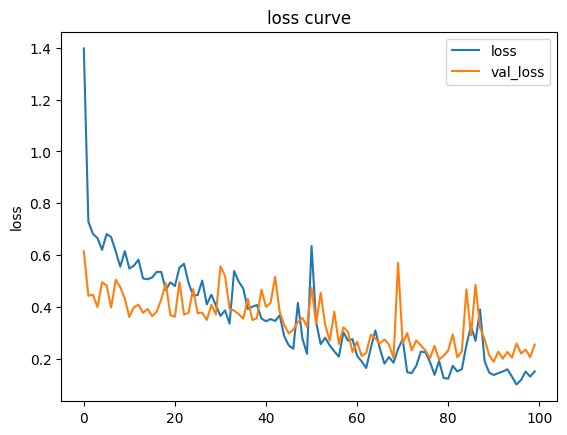

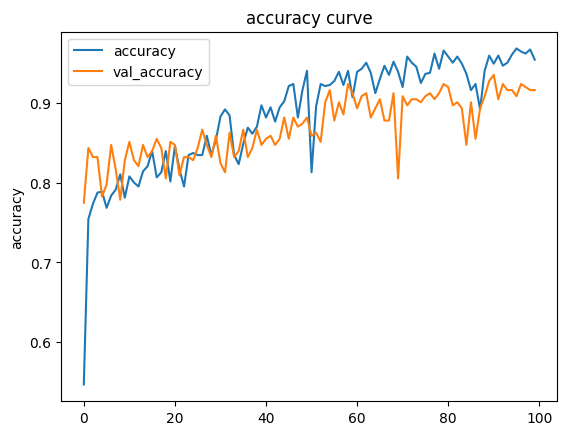

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Plot the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
pre=cnn.predict(val_data)
pre=np.argmax(pre,axis=1)

9/9 [==============================] - 1s 67ms/step


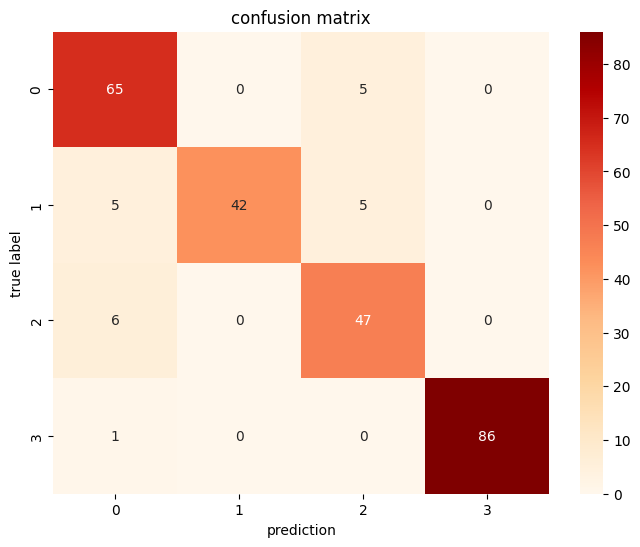

In [ ]:
import seaborn as sn
cm=confusion_matrix(pre,np.argmax(val_label,axis=1))
fit=plt.figure(figsize=(8,6))
plt.title('confusion matrix')
sn.heatmap(cm,annot=True,cmap='OrRd',fmt='g')
plt.xlabel('prediction')
plt.ylabel('true label')
plt.show()

# Output the csv file

In [ ]:
import pandas as pd

In [ ]:
prediction=cnn.predict(te_data)
prediction=np.argmax(prediction,axis=1)
prediction

3/3 [==============================] - 1s 558ms/step


array([0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 1, 3, 3, 0, 2, 2, 1, 1, 1, 0, 3, 0,
       2, 2, 3, 3, 3, 3, 0, 2, 2, 0, 2, 1, 0, 0, 2, 3, 0, 3, 0, 3, 1, 3,
       3, 3, 1, 0, 2, 1, 1, 2, 0, 2, 1, 3, 3, 2, 2, 3, 3, 3, 2, 1, 1, 1,
       3, 0, 0, 0, 1, 3, 3, 3, 0])

In [ ]:
test_label=pd.DataFrame()
test_label['image_id']=te_filename
test_label['labels']=prediction
test_label=test_label.sort_values(by='image_id')
test_label.to_csv('/content/drive/MyDrive/電腦視覺深度學習實作與應用/weather_image/predict_label.csv',index=False) #結果轉csv檔

# Part3: Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.5),
])

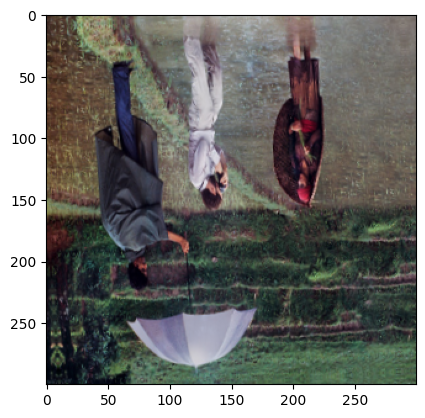

In [ ]:
data=tr_data[1]
data=data_augmentation(data)
plt.imshow(data)